In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()
inspector = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

#### Find the most recent date in the data set.
#dates are in Measure
#check columns
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])
mostrecent = session.query(Measure.date).order_by(desc(Measure.date)).first()
mostrecent

In [10]:
#most recent date in dt format is '2017, 8, 23'

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


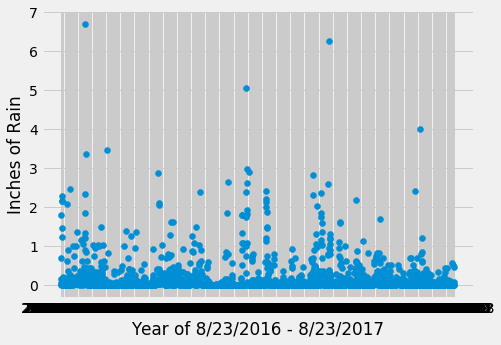

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
prevyear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(prevyear)

# Perform a query to retrieve the data and precipitation scores
my_query = session.query(Measure.date, Measure.prcp).\
filter(Measure.date >= prevyear).\
order_by(Measure.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(my_query, columns =['Date', 'Precipitation']) 
df = df.set_index('Date')
df = df.dropna()
display(df)
# Sort the dataframe by date (query already ordered by date)

# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter((df.index), df["Precipitation"])
#ax.axes.xaxis.set_visible(False)
plt.ylabel("Inches of Rain")
plt.xlabel("Year of 8/23/2016 - 8/23/2017")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#use describe
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
#check columns 
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])
#look at data in df 
station_query = session.query(Station.station, Station.name).all()
station_df = pd.DataFrame(station_query, columns =['Station','Name'])
display(station_df)
print(f"There are {len(station_df['Station'])} stations in the dataset.")

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


,Station,Name
0,USC00519397,"WAIKIKI 717.2, HI US"
1,USC00513117,"KANEOHE 838.1, HI US"
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,USC00517948,"PEARL CITY, HI US"
4,USC00518838,"UPPER WAHIAWA 874.3, HI US"
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
6,USC00519281,"WAIHEE 837.5, HI US"
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
8,USC00516128,"MANOA LYON ARBO 785.2, HI US"


There are 9 stations in the dataset.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station_query = session.query(Measure.station,\
                                     func.count(Measure.station))\
                                    .group_by(Measure.station)\
                                    .order_by(desc(func.count(Measure.station))).all()

active_station_query                                              

                                              



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stn_temp_query = session.query(Measure.station, Measure.tobs).\
filter(Measure.station == 'USC00519281').\
all()
stn_temp_df = pd.DataFrame(stn_temp_query, columns =['Station','Temp'])
temps = stn_temp_df['Temp']
max_temp = temps.max()
min_temp = temps.min()
avg_temp = temps.mean()
avg_temp = "{:.2f}".format(avg_temp)
stn_temp_df.head()
print(f"The highest temperature at the most active station is {max_temp}.")
print(f"The lowest temperature at the most active station is {min_temp}.")
print(f"The average temperature at the most active station is {avg_temp}.")

The highest temperature at the most active station is 85.0.
The lowest temperature at the most active station is 54.0.
The average temperature at the most active station is 71.66.


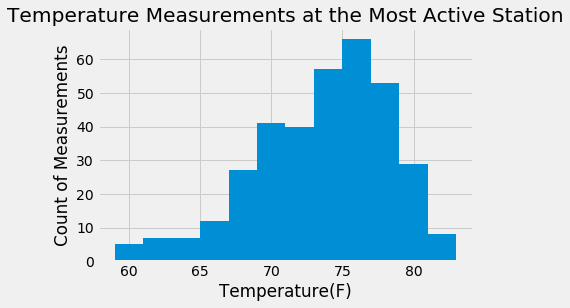

,Date,Station,Temp
0,2017-08-18,USC00519281,79.0
1,2017-08-17,USC00519281,76.0
2,2017-08-16,USC00519281,76.0
3,2017-08-15,USC00519281,77.0
4,2017-08-14,USC00519281,77.0


In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lastyear_mostactive = session.query(Measure.date, Measure.station, Measure.tobs).\
filter(Measure.date >= prevyear).\
filter(Measure.station == 'USC00519281').\
order_by(desc(Measure.date)).all()
lastyear_mostactive
#order into df for histogram
lastyear_mostactive_df =pd.DataFrame(lastyear_mostactive, columns =['Date', 'Station','Temp'])
plt.hist(lastyear_mostactive_df['Temp'], bins=12)
plt.xlabel("Temperature(F)")
plt.ylabel("Count of Measurements")
plt.title("Temperature Measurements at the Most Active Station")
plt.show()
lastyear_mostactive_df.head()

# Close session

In [ ]:
# Close Session
session.close()